# Anomaly Detection on CIFAR-10 with Deep One-Class Classification

This notebook implements a Deep SVDD-style anomaly detector using CIFAR-10 data. The 'airplane' class is treated as normal and all others as anomalies.

In [3]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def filter_dataset(dataset, normal_class=0):
    normal_data = []
    for img, label in dataset:
        if label == normal_class:
            normal_data.append(img.numpy().flatten())
    return np.array(normal_data)

def full_test_dataset(dataset, normal_class=0):
    data = []
    labels = []
    for img, label in dataset:
        data.append(img.numpy().flatten())
        labels.append(0 if label == normal_class else 1)
    return np.array(data), np.array(labels)

X_train = filter_dataset(trainset)
X_test, y_test = full_test_dataset(testset)

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:50<00:00, 1.54MB/s]


In [7]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

center = np.mean(X_train_pca, axis=0)
distances = np.linalg.norm(X_test_pca - center, axis=1)
svdd_scores = (distances - distances.min()) / (distances.max() - distances.min())
svdd_pred = (svdd_scores > 0.5).astype(int)

In [9]:
svm = OneClassSVM(gamma='auto').fit(X_train_pca)
svm_scores = -svm.decision_function(X_test_pca)
svm_pred = (svm.predict(X_test_pca) == -1).astype(int)

In [11]:
acc_svdd = accuracy_score(y_test, svdd_pred)
prec_svdd = precision_score(y_test, svdd_pred)
rec_svdd = recall_score(y_test, svdd_pred)

acc_svm = accuracy_score(y_test, svm_pred)

fpr_svdd, tpr_svdd, _ = roc_curve(y_test, svdd_scores)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
roc_auc_svdd = auc(fpr_svdd, tpr_svdd)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print("Deep SVDD Accuracy:", acc_svdd)
print("Precision:", prec_svdd)
print("Recall:", rec_svdd)
print("SVM Accuracy:", acc_svm)

Deep SVDD Accuracy: 0.2766
Precision: 0.9278100775193798
Recall: 0.2127777777777778
SVM Accuracy: 0.6798


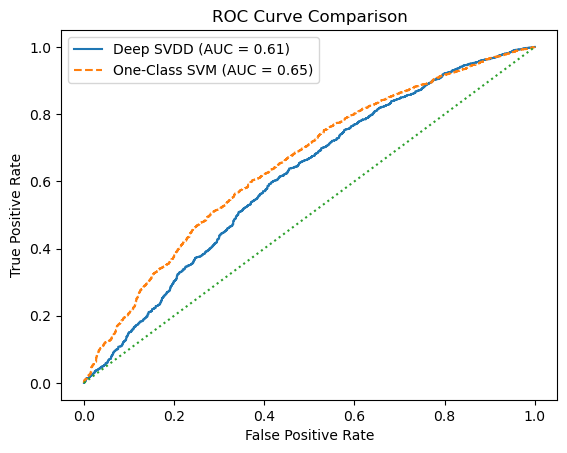

In [22]:
plt.figure()
plt.plot(fpr_svdd, tpr_svdd, label=f'Deep SVDD (AUC = {roc_auc_svdd:.2f})')
plt.plot(fpr_svm, tpr_svm, linestyle='--', label=f'One-Class SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig("roc_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

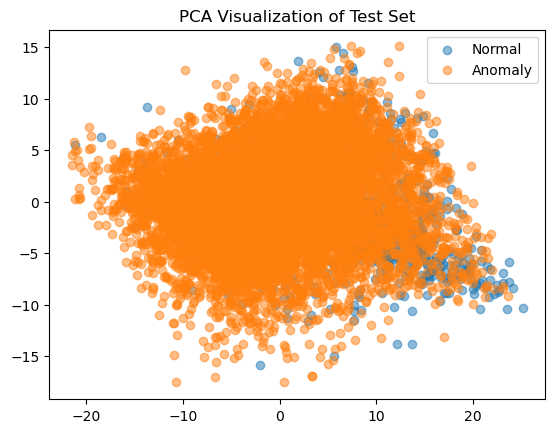

In [24]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_test_pca)

plt.figure()
plt.scatter(X_vis[y_test == 0, 0], X_vis[y_test == 0, 1], label="Normal", alpha=0.5)
plt.scatter(X_vis[y_test == 1, 0], X_vis[y_test == 1, 1], label="Anomaly", alpha=0.5)
plt.title("PCA Visualization of Test Set")
plt.legend()
plt.savefig("pca_visualization.png", dpi=300, bbox_inches='tight')
plt.show()